**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img ,img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
import cv2



**Download and Generate Data**

In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ravirajsinh45/real-life-industrial-dataset-of-casting-product

 91% 91.0M/100M [00:04<00:00, 18.3MB/s]
100% 100M/100M [00:04<00:00, 24.0MB/s] 


In [3]:
!unzip '/content/real-life-industrial-dataset-of-casting-product.zip'

Streaming output truncated to the last 5000 lines.
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5259.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_526.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5260.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5262.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5265.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_527.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5270.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5272.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5274.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_528.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5282.jpeg  
  inflating: casting_data/casting_data/train/def_front/cast_def_0_5283.jpeg  
  inflating: cas

In [4]:
train_generator = ImageDataGenerator(rescale=1/255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2 )
train_data = train_generator.flow_from_directory('../content/casting_data/casting_data/train',
                                          class_mode='binary',
                                          batch_size=8,
                                          target_size=(64,64),
                                          color_mode='grayscale')
test_generator = ImageDataGenerator(rescale=1/255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2 )
test_data = test_generator.flow_from_directory('../content/casting_data/casting_data/test',
                                          class_mode='binary',
                                          batch_size=8,
                                          target_size=(64,64),
                                          color_mode='grayscale')

Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


**Model Definition**

In [5]:
model= Sequential()
#layer1
model.add(tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), 
                                 activation='relu', padding='same',
                                 input_shape=(64,64,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2))

#layer2
model.add(tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), 
                                 activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2))
model.add(tf.keras.layers.Flatten())

#neural network
model.add(tf.keras.layers.Dense(units=128, activation= 'relu'))
model.add(tf.keras.layers.Dense(units=128, activation= 'relu'))
model.add(tf.keras.layers.Dense(units=1, activation= 'sigmoid'))

In [6]:
#configure model for training
model.compile(optimizer= 'Adam', loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.FalseNegatives()])

**Model Training**

In [ ]:
#train
model.fit_generator(train_data, validation_data= test_data, epochs=12)



In [ ]:
model.save('top_model.h5')

**Model Test**

In [ ]:
test_image= load_img('/content/casting_512x512/casting_512x512/def_front/cast_def_0_2304.jpeg',
                     target_size=(64,64), color_mode='grayscale')

t_image=cv2.imread('/content/casting_512x512/casting_512x512/def_front/cast_def_0_2304.jpeg',0)
t_image=t_image/255


In [ ]:

test_image= img_to_array(test_image)
test_image= test_image/255
test_image = np.expand_dims(test_image,axis=0)
result = model.predict(test_image)

if result[0]<=0.5:
    print('OK')
else :
    print('Defective')

Defective


**Visualizing Result**

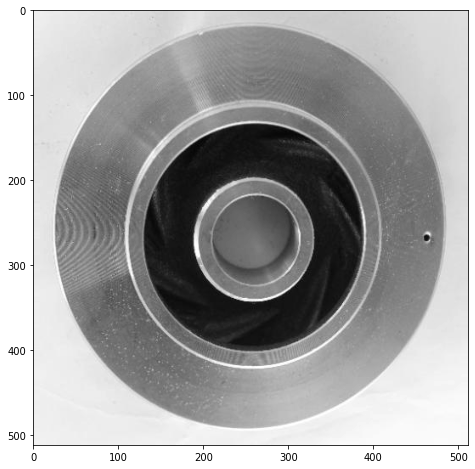

In [ ]:
plt.figure(figsize=(12,8))
plt.imshow(t_image,cmap='gray')
plt.show()

**Under Development**

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  #get photo data
  #get opencv format image 
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes